# Benchmarking Julia Code

This notebook is largely inspired by [this excellent blog post](https://opensourc.es/blog/matrix-multiplication-performance/) and illustrates how to benchmark Julia code, as well as a few useful tricks for optimizing it. You'll need a couple of packages to get it running on your machine. Simply run the next cell to install them.

**NOTE:** Installing packages can take a couple of minutes

In [ ]:
using Pkg
Pkg.add("BenchmarkTools")
Pkg.add("StatsPlots")
Pkg.add("LoopVectorization")

In this notebook, we'll examine the performance of the humble matrix multiplication. We'll start with a naive implementation, and gradually optimize it.

In [9]:
# This function performs the update C = C + A*B without allocating memory
function simple_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for i in 1:m, j in 1:n, k in 1:l
        C[i,j] += A[i,k]*B[k,j]
    end
end

simple_mul! (generic function with 1 method)

In [10]:
n = 256
A = rand(n,n);
B = rand(n,n);
C = rand(n,n);

The Julia standard provides a macro called `@time` to evaluate the running time of an expression (e.g. a function call)

In [11]:
@time simple_mul!(C,A,B)

  0.036164 seconds (26.33 k allocations: 1.449 MiB, 47.19% compilation time)


Note that the above mentions allocations and time spent for compiling the function, so it is not representative of the real performance. If we run the macro again, we see that it takes about 20 ms to compute the product of two 256 times 256 matrices.

In [12]:
@time simple_mul!(C,A,B)

  0.020309 seconds


Using `@time` is fine to get a quick idea of performance, but it only measures the time for one function call. For proper benchmarking, we'll need to bust out the power tools.

Luckily for us, the `BenchmarkTools` package provides just that. It exports several macros, including `@btime` and `@benchmark` which run the expression multiple times to get a better estimate of its performance.

In [13]:
using BenchmarkTools

In [14]:
b_simple = @benchmark simple_mul!(C,A,B)

BenchmarkTools.Trial: 295 samples with 1 evaluation.
 Range (min … max):  15.731 ms … 25.242 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.549 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.935 ms ±  1.358 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃▅▇█▆▅▃▃ ▁▁                                                
  ▇▇████████▇██▇▄▆▇▁▁▄▁▁▄▁▄▁▄▁▄▁▁▄▆▁▁▁▄▁▇▁▁▁▁▁▁▆▁▁▁▁▁▆▁▁▁▁▁▁▄ ▆
  15.7 ms      Histogram: log(frequency) by time        24 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

Looking at the results above, it seems we're a bit under 20 ms for our simple matmul. Let's compare it with the equivalent from the standard library.

In [25]:
using LinearAlgebra
b_mul = @benchmark mul!(C,A,B)

BenchmarkTools.Trial: 5029 samples with 1 evaluation.
 Range (min … max):  640.680 μs … 30.678 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     722.041 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   988.480 μs ±  1.323 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▃▁▂                                                        ▁
  ██████▆▆▇▆▅▆▆▇███▇▇▆▇▆▅▅▆▄▄▅▅▃▄▆▄▄▃▃▁▁▃▃▃▁▁▃▁▁▄▁▃▃▃▁▄▄▄▅▁▅▄▅ █
  641 μs        Histogram: log(frequency) by time       7.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

That's quite the difference, as the standard library is about 20 times faster.

There are a couple of simple things we can do to improve on our implementation. First, we can change the order of the loops. Julia stores its arrays in Row Major Order, so we'll get better performance if we access the array elements column by column.

In [17]:
function better_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for j in 1:n, k in 1:l, i in 1:m
        C[i,j] += A[i,k]*B[k,j]
    end
end

better_mul! (generic function with 1 method)

In [18]:
b_better = @benchmark better_mul!(C,A,B)

BenchmarkTools.Trial: 410 samples with 1 evaluation.
 Range (min … max):  11.314 ms …  15.152 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     12.112 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   12.185 ms ± 487.659 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▂ ▂▅  ▇▅▄█▇▇▇▇▄▅▄▅▁                                     
  ▃▃▁▅▇▇█████▇█████████████▅▆█▅▆▇▆▆▅▃▄▃▄▅▃▄▃▄▁▁▁▁▁▁▁▃▁▁▁▁▃▁▁▁▃ ▅
  11.3 ms         Histogram: frequency by time           14 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

That shaved a bit of performance, but still far from `mul!`. 

The reason reordering the loops improved performance is that modern computer memory is optimized for accessing contiguous areas of memory, so when traversing a Julia matrix by row instead of by column, we are getting what is called "cache misses" where we are jumping between areas of memory that are far apart.

Another simple trick we can use is turning off bounds checking. When accessing a Julia array, the Julia runtime checks that the index we're trying to access is valid (i.e. within the bounds of the array).

If we already know that the index is valid, we can use the macro `@inbounds` to tell the Julia runtime to skip checking it.

In [19]:
function inbounds_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    for j in 1:n, k in 1:l, i in 1:m
        @inbounds C[i,j] += A[i,k]*B[k,j]
    end
end

inbounds_mul! (generic function with 1 method)

In [20]:
b_inbounds = @benchmark inbounds_mul!(C,A,B)

BenchmarkTools.Trial: 2467 samples with 1 evaluation.
 Range (min … max):  1.620 ms …   3.531 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.954 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.019 ms ± 210.870 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

             ▁▅▇█ ▁                                            
  ▂▂▁▂▂▂▂▂▂▅▆████▇█▅▅▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  1.62 ms         Histogram: frequency by time        2.99 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

As we can see, just adding a single macro call improved performance by 10. Not bad! But we can still do better.

The next thing to try is using the basic multithreading support from the standard library.

In [1]:
Threads.nthreads()

1

Unfortunately, I can't get Jupyter notebooks to use multiple threads, so we'll have to do that part in the REPL. Just copy the next two cells in a Julia REPL (You'll have to open a REPL with `julia --threads=4` to start julia with multiple threads available).

In [2]:
function threaded_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    Threads.@threads for j in 1:n # NB. We can only apply this to the outer loop
        for k in 1:l, i in 1:m
          @inbounds C[i,j] += A[i,k]*B[k,j]
        end
    end
end

threaded_mul! (generic function with 1 method)

In [23]:
n = 256; A = rand(n,n); B = rand(n,n); C = rand(n,n)
using BenchmarkTools
b_threaded = @benchmark threaded_mul!(C,A,B)

BenchmarkTools.Trial: 2708 samples with 1 evaluation.
 Range (min … max):  1.577 ms …   2.846 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.803 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.841 ms ± 123.441 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                ▇█▃▅▁                                          
  ▂▂▂▁▁▂▂▂▂▂▃▄▄▅█████▆▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  1.58 ms         Histogram: frequency by time        2.36 ms <

 Memory estimate: 576 bytes, allocs estimate: 6.

In the above, we get no speedup because this Jupyter Notebook only gets a single thread. When I run it in the REPL with 4 threads, I'm getting a median of 612 µs (slightly faster than `mul!`), but this does incur costs as we need to allocate memory for the `@threads` macro.

To finish this notebook, we'll use the `LoopVectorization` package, which export a magic macro called `@turbo` which performs a bunch of optimization on a loop, including using SIMD instructions when it can.

In [4]:
using LoopVectorization

In [6]:
function turbo_mul!(C,A,B)
    m,n = size(C)
    l = size(A,2)
    @turbo for j in 1:n # NB. We can only apply this to the outer loop
        for k in 1:l, i in 1:m
            @inbounds C[i,j] += A[i,k]*B[k,j]
        end
    end
end

turbo_mul! (generic function with 1 method)

In [22]:
b_turbo = @benchmark turbo_mul!(C,A,B)

BenchmarkTools.Trial: 9437 samples with 1 evaluation.
 Range (min … max):  472.698 μs …  1.130 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     521.592 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   526.770 μs ± 23.971 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂   ▁    ▄▂▂▂▂▇▅▃▃▃▅█▆▅▅▄▆▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁                   ▂
  █▆▆▆█▇▇▇▇█████████████████████████████████████▇▇▇▇█▇▇▅▆▅▆▅▆▅ █
  473 μs        Histogram: log(frequency) by time       611 μs <

 Memory estimate: 0 bytes, allocs estimate: 0.

And *voilà*! We actually managed to be a little faster than `mul!` in this case.
All it took was a single macro call.

(NB. Keep in mind we're only looking at matrices of size 256, and our implementations don't check all the things they should to be correct).

Let's wrap up by comparing all our results on a plot. Aside from printing a pretty histogram, `@benchmark` actually returns the data from all its samples in an object, so we can access them.

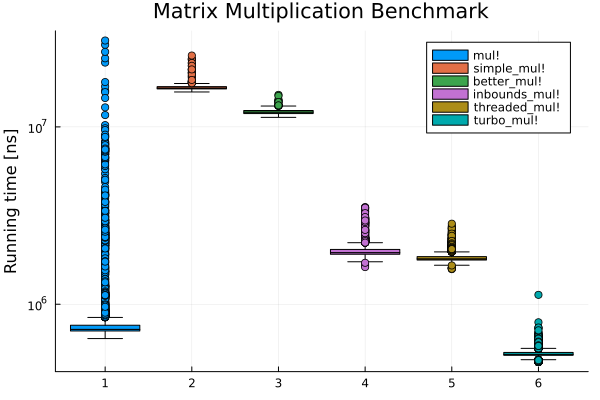

In [26]:
using StatsPlots

boxplot(b_mul.times, label="mul!",
    yscale = :log10,
    ylabel = "Running time [ns]",
    title = "Matrix Multiplication Benchmark"
)
boxplot!(b_simple.times, label="simple_mul!")
boxplot!(b_better.times, label="better_mul!")
boxplot!(b_inbounds.times, label="inbounds_mul!")
boxplot!(b_threaded.times, label="threaded_mul!")
boxplot!(b_turbo.times, label="turbo_mul!")
